1967 169
Epoch 1/10
197/197 [==============================] - 2s 936us/step - loss: 0.3409 - mse: 0.1692 - accuracy: 0.0013
Epoch 2/10
197/197 [==============================] - 0s 890us/step - loss: 0.0891 - mse: 0.0133 - accuracy: 0.0013
Epoch 3/10
197/197 [==============================] - 0s 901us/step - loss: 0.0449 - mse: 0.0042 - accuracy: 8.8523e-04
Epoch 4/10
197/197 [==============================] - 0s 889us/step - loss: 0.0405 - mse: 0.0033 - accuracy: 0.0015
Epoch 5/10
197/197 [==============================] - 0s 961us/step - loss: 0.0381 - mse: 0.0031 - accuracy: 0.0012
Epoch 6/10
197/197 [==============================] - 0s 870us/step - loss: 0.0376 - mse: 0.0033 - accuracy: 0.0013
Epoch 7/10
197/197 [==============================] - 0s 879us/step - loss: 0.0350 - mse: 0.0027 - accuracy: 0.0012
Epoch 8/10
197/197 [==============================] - 0s 896us/step - loss: 0.0379 - mse: 0.0039 - accuracy: 0.0016
Epoch 9/10
197/197 [==============================] - 0s 88

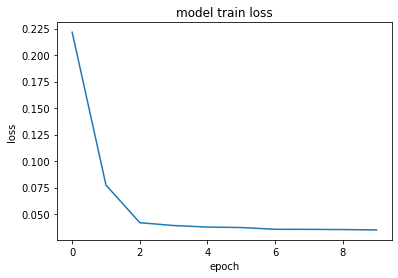

Test Score: 5.00 MAE
Train Score: 7.49 RMSE
Test Score: 4.72 RMSE
Test Score: 3.88 MAE
testPrices:
testPredictions:
1966 167


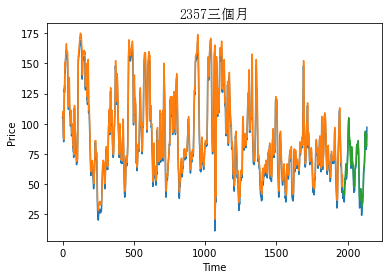

In [5]:
from matplotlib.font_manager import FontProperties

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
# from keras.models import Sequential
# from keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries
from sklearn.metrics import mean_absolute_error
# file is downloaded from finance.yahoo.com, 1.1.1997-1.1.2017
# training data = 1.1.1997 - 1.1.2007
# test data = 1.1.2007 - 1.1.2017
input_file="testaqi.csv"

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(5)

# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

# take close price column[5]
all_y = df[1].values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets, 50% test data, 50% training data
train_size = 1967 #240
#train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train),len(test))#242 245
# reshape into X=t and Y=t+1, timestep 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
#print(trainX.shape[0], 1, trainX.shape[1])
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))#240
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))#243
#print(trainX.shape) 
#print(testX.shape)
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse', 'accuracy'])
#model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=1)
history = model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=1)
# plot train and validation loss
plt.plot(history.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
MAE2 = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Test Score: %.2f MAE' % (MAE2))
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
MAE = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (MAE))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])
#testPrices=scaler.inverse_transform(dataset[train_size:])

print('testPredictions:')
#print(testPredict)

# export prediction and actual prices
#df = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
#df.to_csv("lstm_result.csv", sep=';', index=None)
print(len(testPrices),len(testPredict))
#dict80 = {'truth':np.around(list(testPrices.reshape(-1)), decimals=2),'pred':np.around(list(testPredict.reshape(-1)), decimals=2)}
#--一年
#dict80 = {'date':df[0][test_size-5:],'truth':np.around(list(scaler.inverse_transform(dataset[test_size-5:]).reshape(-1)), decimals=2),'pred':np.around(list(testPredict.reshape(-1)), decimals=2)}
dict80 = {'date':df[0][train_size+2:],'truth':np.around(list(scaler.inverse_transform(dataset[train_size+2:]).reshape(-1)), decimals=2),'pred':np.around(list(testPredict.reshape(-1)), decimals=2)}

df80 = pd.DataFrame(dict80)
df80.to_csv('truth80.csv',index = False)
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.ylabel('Price')
plt.xlabel('Time')
#plt.show()
plt.title("2357三個月",fontproperties=font) 
plt.savefig('plot.jpg')

In [124]:
score = model.evaluate(testY[0],testPredict , verbose=0)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.float64'>, <class 'numpy.ndarray'>

In [116]:
testY[0]

array([443.5, 441.5, 434.5, 424. , 426. , 430.5, 437. , 432. , 422. ,
       416. , 416. , 421. , 420.5, 419. , 383.5, 388. , 382. , 390.5,
       381. , 382. , 381. , 380. , 390. , 401.5, 408.5, 405.5, 398. ,
       392. , 388.5, 394. , 388. , 377. , 378.5, 375. , 360. , 363. ,
       372. , 370.5, 385. , 378.5, 366.5, 373.5, 363. , 336. , 341. ,
       320. , 315.5, 301.5, 274. , 301. , 308. , 330. , 334.5, 343.5,
       340. , 336.5])

In [118]:
testPredict

array([[449.19507],
       [446.0741 ],
       [443.99353],
       [436.71283],
       [425.79895],
       [427.87686],
       [432.55383],
       [439.31277],
       [434.11328],
       [423.72165],
       [417.4934 ],
       [417.4934 ],
       [422.6832 ],
       [422.16403],
       [420.60678],
       [383.9106 ],
       [388.5404 ],
       [382.3691 ],
       [391.1158 ],
       [381.34195],
       [382.3691 ],
       [381.34195],
       [380.31522],
       [390.60056],
       [402.47256],
       [409.71783],
       [406.61115],
       [398.85492],
       [392.66214],
       [389.0553 ],
       [394.7251 ],
       [388.5404 ],
       [377.23758],
       [378.77594],
       [375.18808],
       [359.87875],
       [362.93127],
       [372.11722],
       [370.5834 ],
       [385.45303],
       [378.77594],
       [366.49866],
       [373.65213],
       [362.93127],
       [335.6557 ],
       [340.6709 ],
       [319.73267],
       [315.29147],
       [301.58853],
       [275.23135],


array([448.91, 445.69, 443.55, 436.07, 424.88, 427.01, 431.8 , 438.74,
       433.4 , 422.76, 416.39, 416.39, 421.7 , 421.16, 419.57, 382.3 ,
       386.98, 380.74, 389.58, 379.71, 380.74, 379.71, 378.67, 389.06,
       401.1 , 408.47, 405.3 , 397.42, 391.15, 387.5 , 393.24, 386.98,
       375.57, 377.12, 373.51, 358.15, 361.2 , 370.42, 368.88, 383.86,
       377.12, 364.78, 371.96, 361.2 , 334.02, 339.  , 318.3 , 313.93,
       300.52, 274.97, 300.04, 306.71, 328.09, 332.54, 341.5 , 338.  ],
      dtype=float32)